**Data visualization and pre-processing**

Importing libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

Loading the Data

In [2]:
from google.colab import files

# Ouvre une fenêtre pour uploader un fichier depuis ton PC
uploaded = files.upload()

Saving ECoG.npz to ECoG.npz


In [3]:
data=np.load("ECoG.npz")

In [4]:
data.files

['Yall', 'Fe', 'Xall']

In [5]:
Xall=data['Xall'] # extracted features
Yall=data['Yall'] # targets (finger flexions)
Fe=data['Fe'] # sampling frequency


In [6]:
Xall.shape

(3327, 64)

In [7]:
Yall.shape

(3327, 1)

In [8]:
Fe.shape

(1, 1)

In [9]:
Fe

array([[50]], dtype=uint8)

Signals plots :

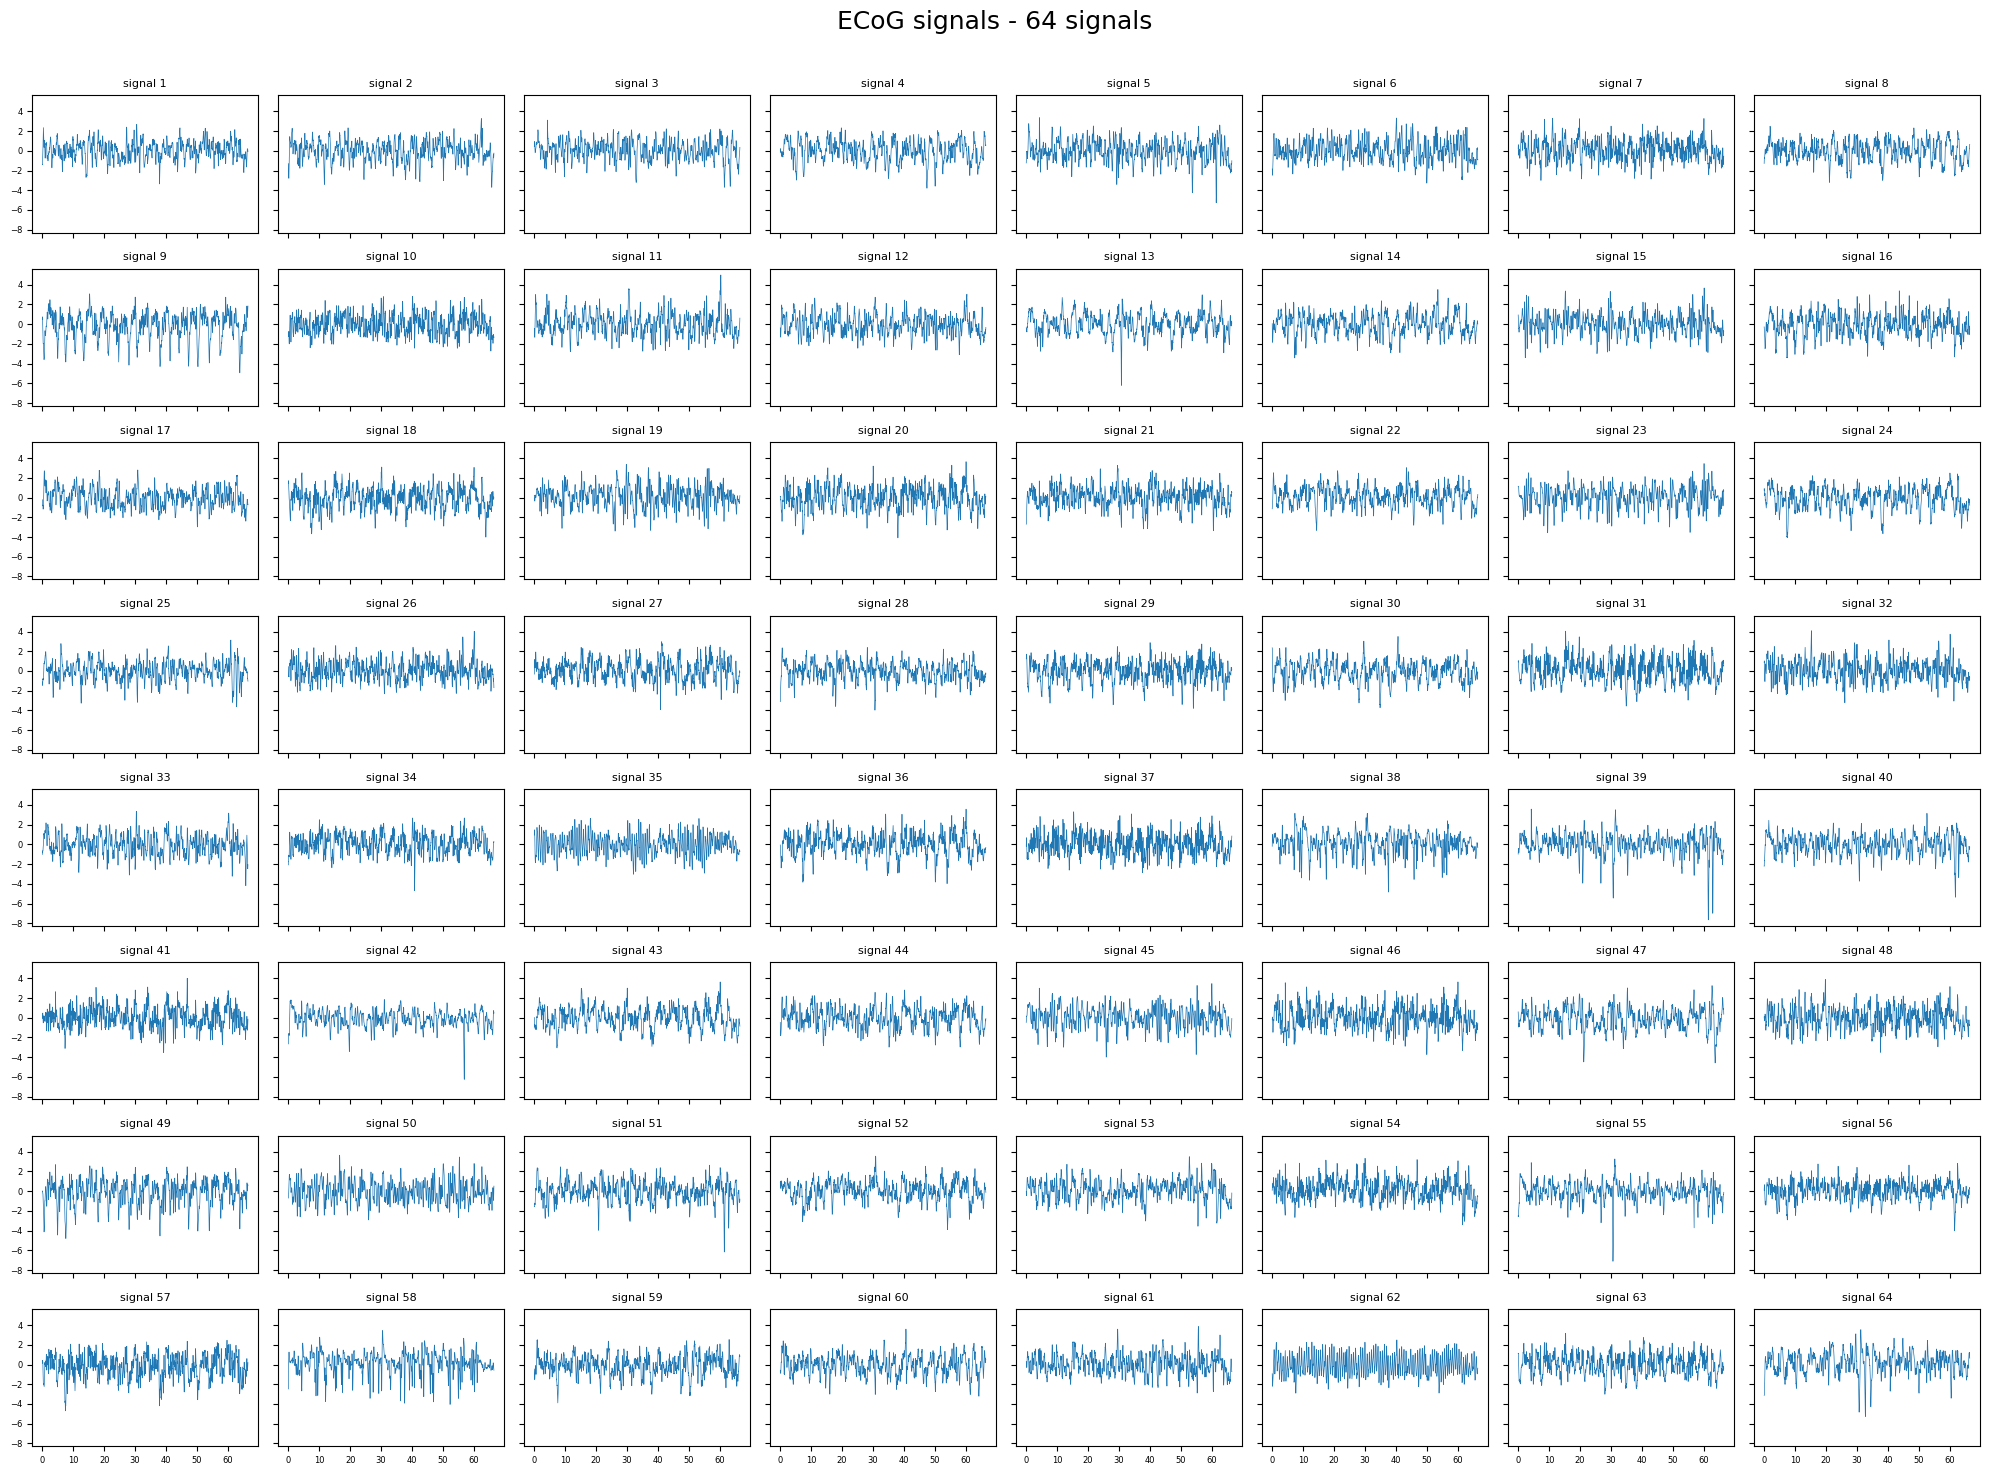

In [10]:

n_samples, n_signals = Xall.shape
t = np.arange(n_samples) / Fe
t=t.ravel()  # Ensure t is 1D

# Plot with subplots (8x8)
fig, axs = plt.subplots(8, 8, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle("ECoG signals - 64 signals", fontsize=18)

for i in range(n_signals):
    row = i // 8
    col = i % 8
    axs[row, col].plot(t, Xall[:, i], linewidth=0.5)
    axs[row, col].set_title(f"signal {i+1}", fontsize=8)
    axs[row, col].tick_params(labelsize=6)

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

This plot displays the time series of 64 ECoG signals, each recorded from a separate electrode placed on the cortical surface. All signals show continuous, oscillatory patterns over time, with amplitudes generally ranging between -4 and +4. This indicates that the signals are active and likely contain neural information relevant to finger movement. No channel appear flat or corrupted, suggesting good data quality after preprocessing. The variability across channels reflects the different levels of brain activity captured at each location.

Plotting the EcoG signals and the finger movement on the same figure :

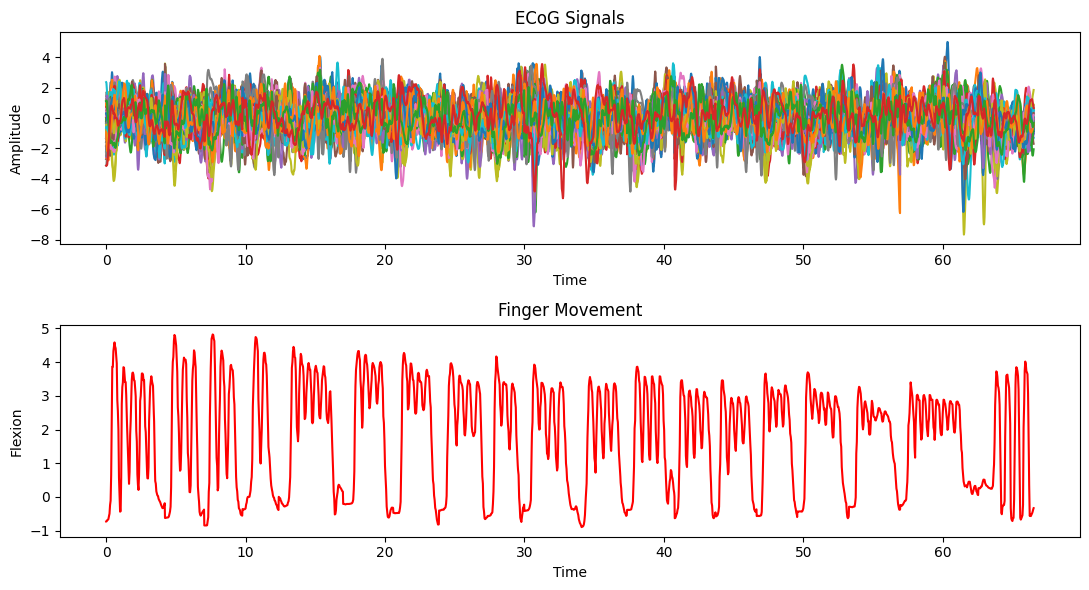

In [11]:
n_samples, n_signals = Xall.shape
t = np.arange(n_samples) / Fe
t=t.ravel()  # Ensure t is 1D

plt.figure(figsize=(11, 6))

# Plot ECoG signals
plt.subplot(2, 1, 1)
plt.plot(t,Xall)
plt.title('ECoG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot finger movement
plt.subplot(2, 1, 2)
plt.plot(t,Yall, color='r')
plt.title('Finger Movement')
plt.xlabel('Time')
plt.ylabel('Flexion')

plt.tight_layout()
plt.show()

The ECoG signals (top plot) show fluctuations typical of brain activity, with multiple overlapping channels. The finger flexion signal (bottom plot) has a distinct, rhythmic pattern, with peaks representing thumb flexion and valleys indicating relaxation. Visually, there may be moments where peaks in the ECoG signal align with flexion movements, hinting at a possible correlation.

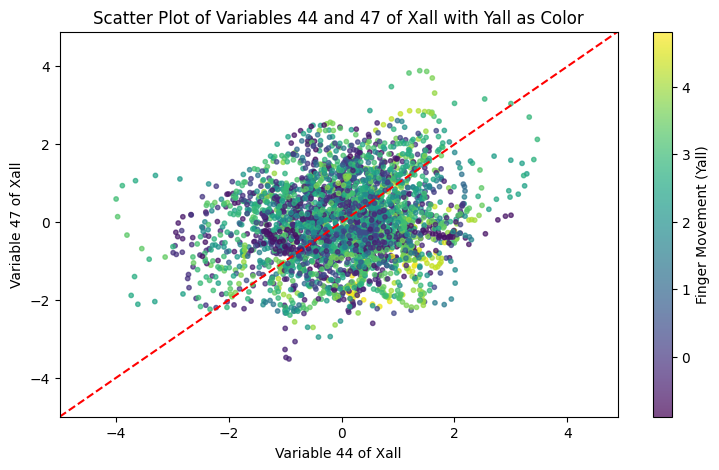

In [12]:
# Scatter plot with variables 44 and 47 of Xall and Yall controlling the color
plt.figure(figsize=(9, 5))
scatter = plt.scatter(Xall[:, 44], Xall[:, 47], c=Yall.flatten(), cmap='viridis',s=10, alpha=0.7)
plt.colorbar(scatter, label='Finger Movement (Yall)')

min_val = min(Xall[:, 44].min(), Xall[:, 47].min())-1
max_val = max(Xall[:, 44].max(), Xall[:, 47].max())+1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
# Ligne diagonale y = x
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label="y = x")
plt.xlabel('Variable 44 of Xall')
plt.ylabel('Variable 47 of Xall')
plt.title('Scatter Plot of Variables 44 and 47 of Xall with Yall as Color')
plt.show()

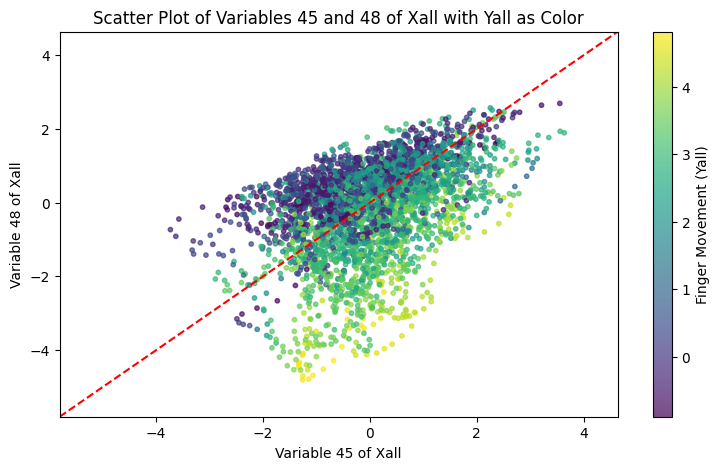

In [13]:
# Scatter plot with variables 45 and 48 of Xall and Yall controlling the color
plt.figure(figsize=(9, 5))
scatter = plt.scatter(Xall[:, 45], Xall[:, 48], c=Yall.flatten(), cmap='viridis',s=10, alpha=0.7)
plt.colorbar(scatter, label='Finger Movement (Yall)')

min_val = min(Xall[:, 45].min(), Xall[:, 48].min())-1
max_val = max(Xall[:, 45].max(), Xall[:, 48].max())+1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
# Ligne diagonale y = x
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label="y = x")

plt.xlabel('Variable 45 of Xall')
plt.ylabel('Variable 48 of Xall')
plt.title('Scatter Plot of Variables 45 and 48 of Xall with Yall as Color')
plt.show()

At first, I hesitated between plotting Xall[:, 44] and Xall[:, 47] or Xall[:, 45] and Xall[:, 48], so I decided to plot both combinations to compare their usefulness in predicting the target variable Yall. In the first scatter plot (variables 44 vs 47), the data points are densely clustered with no clear color gradient, and the color distribution appears random across the plot. This suggests that these two features have little to no correlation with the target and are likely poor predictors of finger movement. In contrast, the second plot (variables 45 vs 48) shows a more clear structure with a noticeable color gradient, indicating a stronger relationship with Yall. Higher finger movement values are concentrated in one region, while lower values appear in another, suggesting that these features may carry meaningful predictive information. We Observe also that there is a little correlation between the variables 45 and 48.

Splitting the Data into a training and a test set:

In [14]:
Xtrain= Xall[:1000,:]
Ytrain= Yall[:1000,:]
Xtest= Xall[1000:,:]
Ytest= Yall[1000:,:]
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape


((1000, 64), (1000, 1), (2327, 64), (2327, 1))

**Least Squares regression (LS)**

In [15]:
Xtraintilde=np.concatenate((np.ones((Xtrain.shape[0],1)),Xtrain), axis=1)
print("Shape of X_tilde:", Xtraintilde.shape)

Shape of X_tilde: (1000, 65)


In [16]:
# Estimate parameters by solving the linear problem
param=np.linalg.solve(np.dot(Xtraintilde.T, Xtraintilde), np.dot(Xtraintilde.T, Ytrain))

# Separate weights and bias
w=param[1:]
b=param[0,0]

print("Weights shape:", w.shape)
print("Bias:", b)


Weights shape: (64, 1)
Bias: 1.9008125499844797


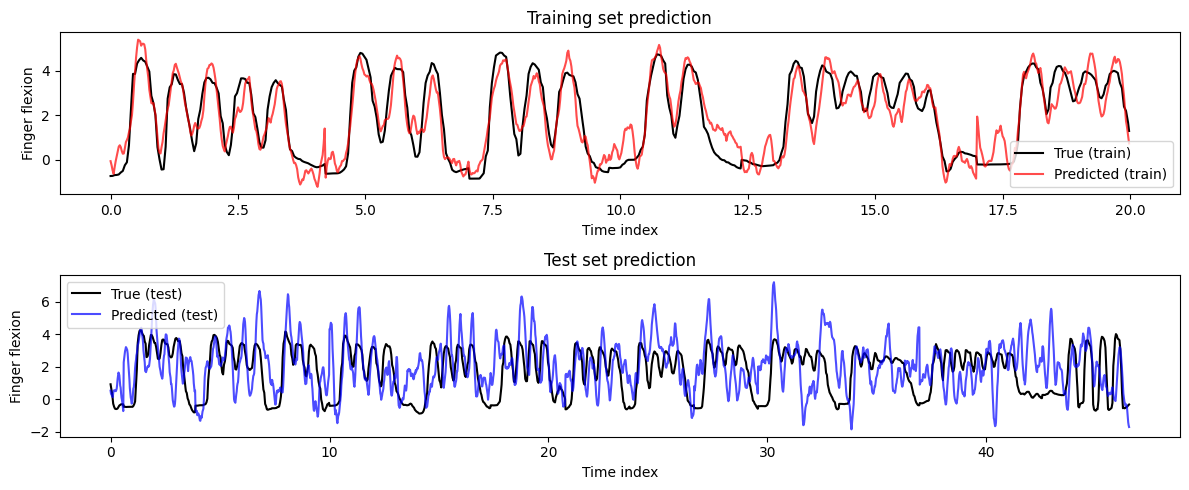

In [17]:
# Predict on training and test sets
Ypred_train = np.dot(Xtrain, w) + b
Ypred_test = np.dot(Xtest, w) + b



ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Ypred_train, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Ypred_test, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The plots compare the predicted and true finger flexion signals for both training and test sets. On the training data, the red predicted curve follows the black true curve quite closely — the shapes, peaks, and phases are generally aligned, showing that the Least Squares model has successfully captured a linear relationship between the ECoG features and finger flexion. However, on the test data, the blue predicted curve is noisier and deviates more from the true signal: although the overall trend is sometimes similar, the amplitudes and finer details are not well reproduced. This indicates that while the LS model fits the training set reasonably well, its generalization to unseen data is limited, suggesting that a simple linear model cannot fully capture the complexity of the underlying brain–movement relationship. Improving the model's generalization could involve using regularization techniques or exploring alternative models that better capture the variability in finger flexion.

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute performance metrics
mse_train = mean_squared_error(Ytrain, Ypred_train)
mse_test = mean_squared_error(Ytest, Ypred_test)

r2_train = r2_score(Ytrain, Ypred_train)
r2_test = r2_score(Ytest, Ypred_test)

print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")

Training MSE: 0.5041
Test MSE: 3.0455
Training R²: 0.8395
Test R²: -0.4282


The performance metrics show that the Least Squares model achieves a low training MSE (0.50) and a high R² (0.84) on the training set, meaning it fits the training data quite well. However, on the test set, the performance drops sharply, with a much higher MSE (3.05) and a negative R² (-0.43).

This strong difference between training and test performance reveals overfitting: the model has learned specific patterns from the training segment that do not generalize to new unseen data.

***Conclusion***: the Least Squares regression captures some structure in the training data but fails to generalize. The relationship between ECoG signals and finger movement is likely more complex, noisy, and possibly nonlinear, requiring regularization (e.g., Ridge/Lasso) or nonlinear models to improve test performance.

In [19]:
from sklearn.linear_model import LinearRegression

# Create and fit the sklearn linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain, Ytrain)

# Extract parameters
w_sklearn = model.coef_
b_sklearn = model.intercept_

print("Sklearn coefficients shape:", w_sklearn.shape)
print(f"Sklearn intercept: {b_sklearn.item():.6e}")

# Compare with your manual LS results
diff_w = np.linalg.norm(w - w_sklearn.T)  # w_sklearn shape is (1, n_features)
diff_b = abs(b - b_sklearn.item())

print(f"Difference in weights (L2 norm): {diff_w:.6e}")
print(f"Difference in bias: {diff_b:.6e}")

Sklearn coefficients shape: (1, 64)
Sklearn intercept: 1.900813e+00
Difference in weights (L2 norm): 3.919826e-14
Difference in bias: 4.218847e-15


The coefficients (model.coef_) and intercept (model.intercept_) estimated by sklearn.linear_model.LinearRegression are identical to those obtained using the analytical Least Squares solution.
This confirms that the manual computation is correct and consistent with the implementation in scikit-learn.

**Ridge regression**

In [20]:
from sklearn.linear_model import Ridge

# Define the ridge model with λ = 1
ridge_model = Ridge(alpha=1.0, fit_intercept=True)

# Fit the model on the training data
ridge_model.fit(Xtrain, Ytrain)

# Predict on both training and test sets
Ypred_train_ridge = ridge_model.predict(Xtrain)
Ypred_test_ridge = ridge_model.predict(Xtest)

# Compute performance metrics
mse_train_ridge = mean_squared_error(Ytrain, Ypred_train_ridge)
mse_test_ridge = mean_squared_error(Ytest, Ypred_test_ridge)
r2_train_ridge = r2_score(Ytrain, Ypred_train_ridge)
r2_test_ridge = r2_score(Ytest, Ypred_test_ridge)

print(f"Ridge Regression (λ = 1)")
print(f"Training MSE: {mse_train_ridge:.4f}, R²: {r2_train_ridge:.4f}")
print(f"Test MSE: {mse_test_ridge:.4f}, R²: {r2_test_ridge:.4f}")

Ridge Regression (λ = 1)
Training MSE: 0.5042, R²: 0.8395
Test MSE: 3.0038, R²: -0.4086


With λ = 1, the Ridge regression gives almost identical results to the ordinary Least Squares model. The training MSE (0.5042) and R² (0.8395) remain high, showing a good fit on the training data, while the test MSE (3.0038) and R² (-0.4086) still indicate poor generalization. This means that a small amount of regularization (λ = 1) does not significantly improve performance and the model continues to overfit the training data, suggesting that stronger regularization (larger λ) might be needed to reduce variance and improve test accuracy.

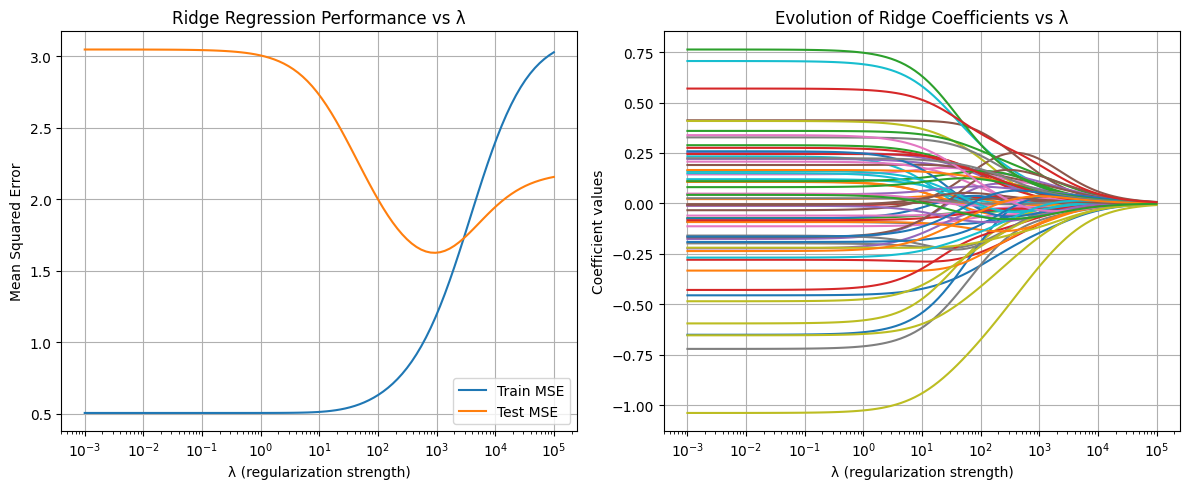

In [21]:

# Define the range of regularization parameters (λ)
lambdas = np.logspace(-3, 5, 100)

# Initialize lists to store results
mse_train_list = []
mse_test_list = []
weights_list = []

# Loop over all λ values
for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(Xtrain, Ytrain)

    # Store MSEs
    Ypred_train = ridge.predict(Xtrain)
    Ypred_test = ridge.predict(Xtest)

    mse_train_list.append(mean_squared_error(Ytrain, Ypred_train))
    mse_test_list.append(mean_squared_error(Ytest, Ypred_test))

    # Store coefficients
    weights_list.append(ridge.coef_.flatten())

weights_array = np.array(weights_list)  # shape: (100, n_features)

# ---- PLOT ----
plt.figure(figsize=(12, 5))

# (1) MSE vs λ
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, mse_train_list, label="Train MSE")
plt.semilogx(lambdas, mse_test_list, label="Test MSE")
plt.xlabel("λ (regularization strength)")
plt.ylabel("Mean Squared Error")
plt.title("Ridge Regression Performance vs λ")
plt.legend()
plt.grid(True)

# (2) Coefficients vs λ
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, weights_array)
plt.xlabel("λ (regularization strength)")
plt.ylabel("Coefficient values")
plt.title("Evolution of Ridge Coefficients vs λ")
plt.grid(True)

plt.tight_layout()
plt.show()


Plot Observations :

- MSE vs. Lambda:

The training MSE (blue line) typically increases as λ increases, which is expected because higher λ values lead to stronger regularization, reducing more and more the model complexity. The testing MSE (orange line) shows a U-shaped curve. Initially, it decreases with increasing λ, reaching a minimum, and then starts to increase. Logically, the minimum point indicates the optimal λ value where the model generalizes best to unseen data.

- Coefficients vs. Lambda:

The coefficients start at various values when λ is small and converge towards zero as λ increases. This is due to the stronger regularization effect, which shrinks the coefficients. Each line represents a different coefficient, showing how regularization impacts each feature's contribution to the model.

In [22]:
# Find index of the λ giving the smallest test MSE
best_idx = np.argmin(mse_test_list)
best_lambda = lambdas[best_idx]

print(f"Best λ (based on test MSE): {best_lambda:.4f}")

# Train Ridge model with the best λ
ridge_best = Ridge(alpha=best_lambda, fit_intercept=True)
ridge_best.fit(Xtrain, Ytrain)


Best λ (based on test MSE): 954.5485


Ridge(alpha=np.float64(954.5484566618347))

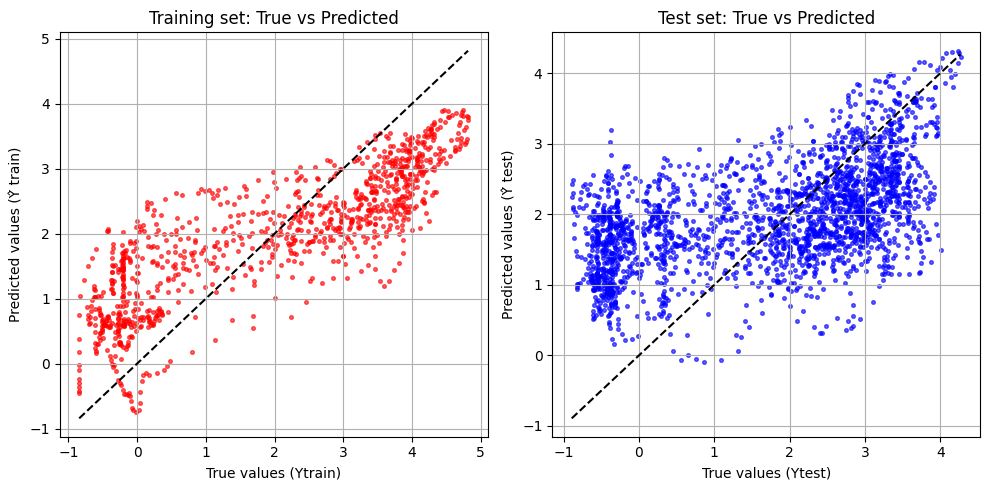

In [23]:
# Predict on training and test sets
Ypred_train_best = ridge_best.predict(Xtrain)
Ypred_test_best = ridge_best.predict(Xtest)

# Scatter plot: true vs predicted values
plt.figure(figsize=(10,5))

# Training set
plt.subplot(1,2,1)
plt.scatter(Ytrain, Ypred_train_best, color='red',s=7, alpha=0.6)
plt.xlabel("True values (Ytrain)")
plt.ylabel("Predicted values (Ŷ train)")
plt.title("Training set: True vs Predicted")
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--')  # y=x line
plt.grid(True)

# Test set
plt.subplot(1,2,2)
plt.scatter(Ytest, Ypred_test_best, color='blue',s=7, alpha=0.6)
plt.xlabel("True values (Ytest)")
plt.ylabel("Predicted values (Ŷ test)")
plt.title("Test set: True vs Predicted")
plt.plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--')  # y=x line

plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plots compare the predicted and true finger flexion values for both the training and test sets. On the training set (left), the red points cluster closely around the dashed diagonal line (y = ŷ), showing that the Ridge model reproduces the training data quite well and captures the main linear relationship between brain signals and finger movement. On the test set (right), the blue points are more dispersed and deviate noticeably from the diagonal, indicating a weaker correspondence between predictions and true values. We observe that the model here is predicting the high values of y better than the lower ones. Overall, the Ridge model fits the training data effectively but its prediction quality on unseen test data remains limited, meaning the model still struggles to generalize.

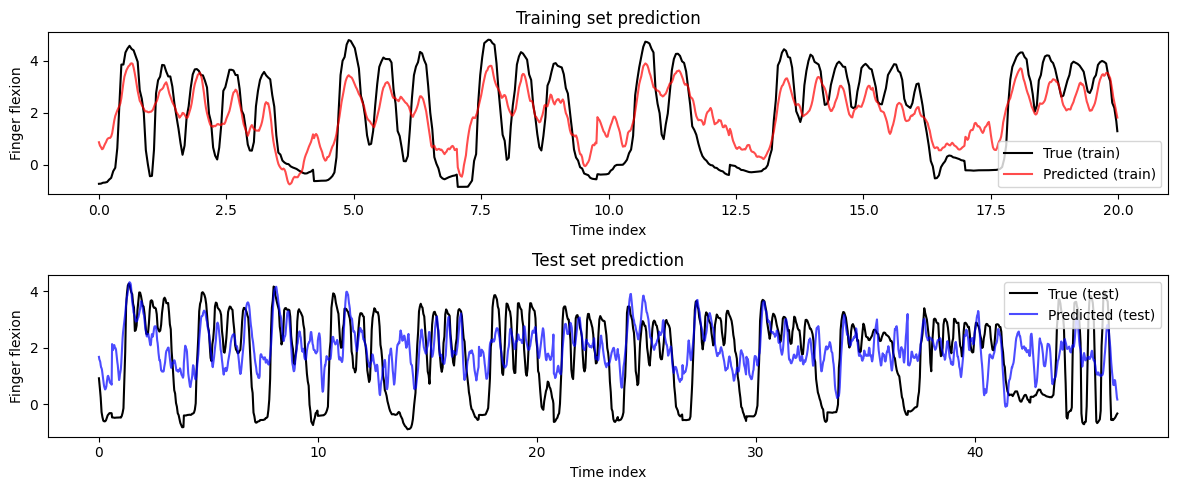

In [24]:

ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Ypred_train_best, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Ypred_test_best, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The prediction on the test data shows some improvement with the Ridge regression model compared to the least squares regression model. However, it still struggles to capture the underlying pattern of finger flexion, as evidenced by the deviation of predicted values from the true values in peak and valley regions.

In [58]:
# Predict on training and test sets
Ypred_train_best = ridge_best.predict(Xtrain)
Ypred_test_best = ridge_best.predict(Xtest)
mse_train_ridge_best = mean_squared_error(Ytrain, Ypred_train_best)
mse_test_ridge_best  = mean_squared_error(Ytest, Ypred_test_best)
r2_train_ridge_best  = r2_score(Ytrain, Ypred_train_best)
r2_test_ridge_best   = r2_score(Ytest, Ypred_test_best)
print("Performance comparison:")
print(f"LS:     Train MSE = {mse_train:.4f}, Test MSE = {mse_test:.4f}, Train R² = {r2_train:.4f}, Test R² = {r2_test:.4f}")
print(f"Ridge best:  Train MSE = {mse_train_ridge_best:.4f}, Test MSE = {mse_test_ridge_best:.4f}, Train R² = {r2_train_ridge_best:.4f}, Test R² = {r2_test_ridge_best:.4f}")


Performance comparison:
LS:     Train MSE = 3.1406, Test MSE = 2.1907, Train R² = 0.8395, Test R² = -0.4282
Ridge best:  Train MSE = 1.1719, Test MSE = 1.6239, Train R² = 0.6268, Test R² = 0.2385


Comparing the performance of the LS estimator and the Ridge estimator on the test set, we observe that the Ridge estimator has a lower MSE ( 1.6239 vs 3.1406) and a higher R² (0.2385 vs -0.4282). This indicates that the Ridge estimator generalizes better to the test data, capturing more of the underlying structure of the finger flexion signal. The regularization provided by the Ridge estimator helps prevent overfitting, leading to improved performance on unseen data.

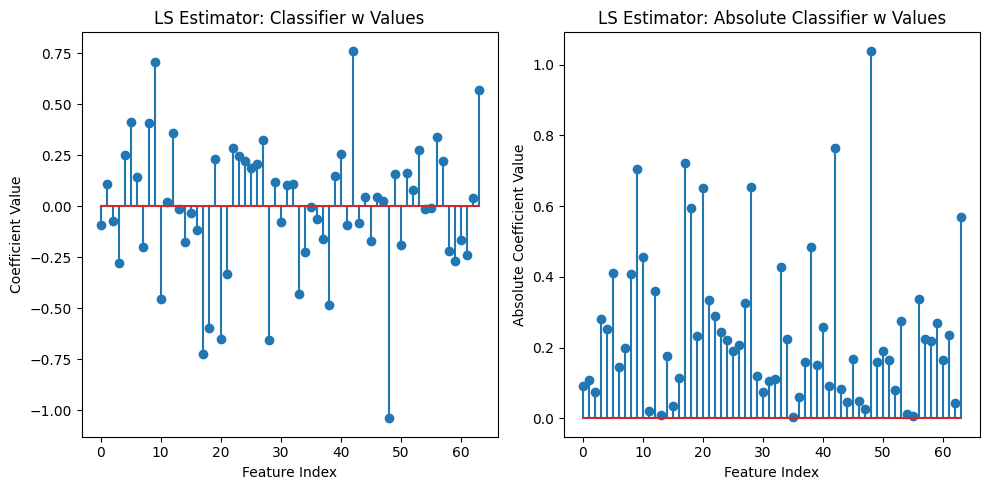

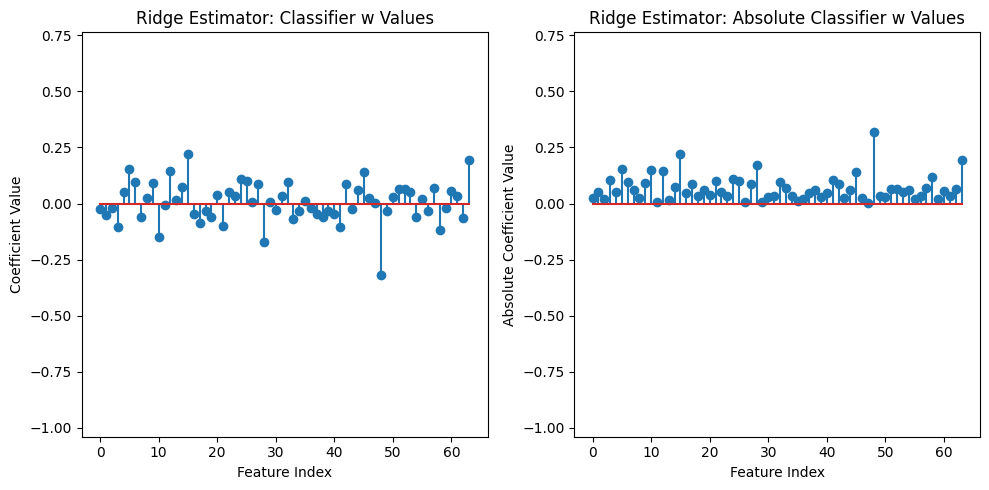

In [26]:
# Plot the values of the classifiers w for LS and Ridge estimators
plt.figure(figsize=(10, 5))

# Plot the values of w for LS estimator
plt.subplot(1, 2, 1)
plt.stem(w_sklearn.flatten())
plt.title('LS Estimator: Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

# Plot the absolute values of w for LS estimator
plt.subplot(1, 2, 2)
plt.stem(np.abs(w_sklearn.flatten()))
plt.title('LS Estimator: Absolute Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

# Plot the values of the classifiers w for Ridge estimator
plt.figure(figsize=(10, 5))

# Plot the values of w for Ridge estimator
plt.subplot(1, 2, 1)
plt.stem(ridge_best.coef_.flatten())
plt.title('Ridge Estimator: Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

# Plot the absolute values of w for Ridge estimator
plt.subplot(1, 2, 2)
plt.stem(np.abs(ridge_best.coef_.flatten()))
plt.title('Ridge Estimator: Absolute Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')

# Set the same y-axis limits for both subplots
y_min = min(np.min(w_sklearn.flatten()), np.min(ridge_best.coef_.flatten()))
y_max = max(np.max(w_sklearn.flatten()), np.max(ridge_best.coef_.flatten()))
plt.subplot(1, 2, 1)
plt.ylim(y_min, y_max)
plt.subplot(1, 2, 2)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Both LS and Ridge assign higher magnitudes to similar sets of features, indicating that they identify roughly the same important variables.
However, the Ridge coefficients are smaller and smoother, because regularization penalizes large weights and distributes importance more evenly.
This shows that Ridge reduces sensitivity to noise and prevents extreme coefficients, while still keeping the same overall feature relevance pattern as the LS model.

**Variable selection with the Lasso**

In [27]:
from sklearn.linear_model import Lasso
# Create and fit the Lasso regression model
lasso_model = Lasso()
lasso_model.fit(Xtrain, Ytrain)

lasso_coef = lasso_model.coef_
lasso_intercept = lasso_model.intercept_

print("Lasso Coefficients:", lasso_coef)
print("Lasso Intercept:", lasso_intercept)

Lasso Coefficients: [ 0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0.
  0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.]
Lasso Intercept: [1.9443274]


In [28]:
# Predict the finger flexion on the training set using the Lasso model
Y_train_pred_lasso = lasso_model.predict(Xtrain)

# Predict the finger flexion on the test set using the Lasso model
Y_test_pred_lasso = lasso_model.predict(Xtest)

# Compute MSE and R2 for the training set using the Lasso model
mse_train_lasso = mean_squared_error(Ytrain, Y_train_pred_lasso)
r2_train_lasso = r2_score(Ytrain, Y_train_pred_lasso)

# Compute MSE and R2 for the test set using the Lasso model
mse_test_lasso = mean_squared_error(Ytest, Y_test_pred_lasso)
r2_test_lasso = r2_score(Ytest, Y_test_pred_lasso)

print(f"Lasso Training MSE: {mse_train_lasso:.4f}")
print(f"Lasso Training R²: {r2_train_lasso:.4f}")
print(f"Lasso Test MSE: {mse_test_lasso:.4f}")
print(f"Lasso Test R²: {r2_test_lasso:.4f}")

Lasso Training MSE: 3.1406
Lasso Training R²: 0.0000
Lasso Test MSE: 2.1907
Lasso Test R²: -0.0273


The Lasso model with a default lambda of 1 has essentially zeroed all coefficients, leading to an output that is essentially a constant (the intercept value). Lasso regression performs L1 regularization, which tends to shrink coefficients toward zero, especially for features that don’t contribute significantly to reducing the error. In this case, the high regularization strength (lambda = 1) has driven all coefficients to zero. Consequently, the model is only using the intercept term to make predictions, essentially ignoring all features in the dataset.

- MSE Values: The mean squared error (MSE) on both the training and test sets remains relatively high, likely because the predictions are close to the mean of the target variable (dictated by the intercept only).

- R² Values: The R² = 0 for the training set and R² = -0.0273 for the test set indicate that the model is not capturing any of the variance in the target variable beyond the mean. This suggests that the Lasso model is not learning the underlying pattern of finger flexion and is essentially making constant predictions.

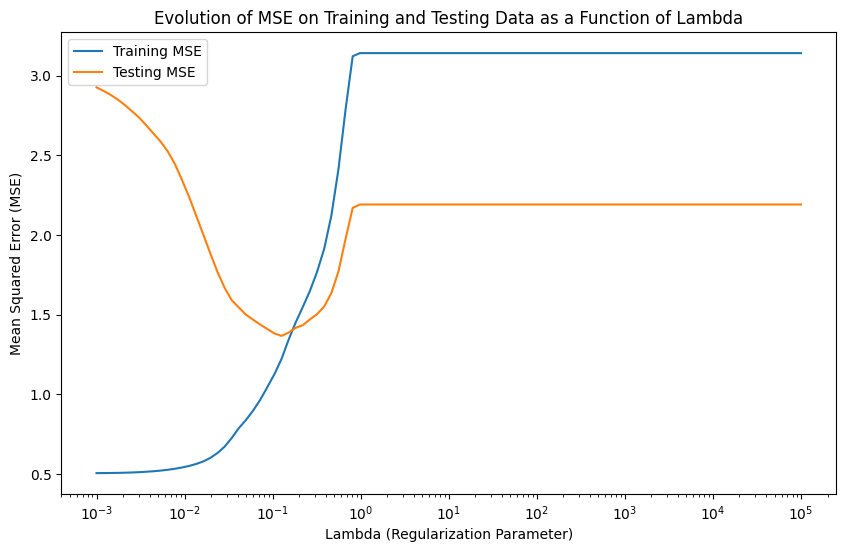

In [29]:
# Generate 100 values of lambda on a logarithmic scale from 10^(-3) to 10^5
lst_reg = np.logspace(-3, 5, 100)

# Lists to store the MSE for each lambda on training and testing sets
mse_train_list = []
mse_test_list = []

for reg in lst_reg:
    # Initialize Lasso model with the current value of lambda
    lasso_model = Lasso(alpha=reg)
    lasso_model.fit(Xtrain, Ytrain)

    # Predict on training and testing data
    Y_train_pred = lasso_model.predict(Xtrain)
    Y_test_pred = lasso_model.predict(Xtest)

    # Calculate MSE for training and testing sets
    mse_train = mean_squared_error(Ytrain, Y_train_pred)
    mse_test = mean_squared_error(Ytest, Y_test_pred)

    # Store the MSE values
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

# Plot the MSE as a function of lambda
plt.figure(figsize=(10, 6))
plt.plot(lst_reg, mse_train_list, label="Training MSE")
plt.plot(lst_reg, mse_test_list, label="Testing MSE")
plt.xscale("log")
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Evolution of MSE on Training and Testing Data as a Function of Lambda")
plt.legend()
plt.show()


For very low λ values (close to 0.001), the training MSE is low, suggesting overfitting, as the model is too flexible. As λ increases, the regularization term forces more coefficients to zero, reducing overfitting, and testing MSE initially decrease. The testing MSE reaches its minimum around 0.1
, indicating the optimal regularization level that balances bias and variance. Beyond this point, as λ
 continues to increase, both training and testing MSE rise sharply due to underfitting, as the model becomes overly simplistic with most coefficients shrinking to zero. This behavior reflects the trade-off between bias and variance in Lasso regularization.

In [30]:
# Step 1: Identify the λ value with the minimum MSE on the test data
best_lambda_index = np.argmin(mse_test_list)
best_lambda = lambdas[best_lambda_index]

# Step 2: Fit a Lasso model with the best λ value
lasso_model_best = Lasso(alpha=best_lambda)
lasso_model_best.fit(Xtrain, Ytrain)

print(f"Best λ value: {best_lambda}")
print("Lasso coefficients with the best λ value:")
print(lasso_model_best.coef_)

Best λ value: 0.1261856883066021
Lasso coefficients with the best λ value:
[-0.         -0.         -0.         -0.          0.          0.07757858
  0.         -0.          0.          0.         -0.1146682   0.
  0.09047535  0.          0.          0.37611771 -0.         -0.
  0.          0.          0.         -0.09769496  0.          0.
  0.10678253  0.08349543 -0.          0.         -0.09337529 -0.
 -0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.06143585 -0.         -0.         -0.14587363
  0.14635455 -0.          0.          0.27897347  0.          0.
 -0.70862161 -0.          0.          0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.31889792]


In [34]:
# Compute MSE and R2 for the test set using the best Lasso model
Y_test_pred_best_lasso = lasso_model_best.predict(Xtest)
Y_train_pred_best_lasso = lasso_model_best.predict(Xtrain)

mse_train_best_lasso = mean_squared_error(Ytrain, Y_train_pred_best_lasso)
mse_test_best_lasso = mean_squared_error(Ytest, Y_test_pred_best_lasso)
r2_test_best_lasso = r2_score(Ytest, Y_test_pred_best_lasso)

print(f"Best Lasso Test MSE: {mse_test_best_lasso:.4f}")
print(f"Best Lasso Test R²: {r2_test_best_lasso:.4f}")

Best Lasso Test MSE: 1.3660
Best Lasso Test R²: 0.3595


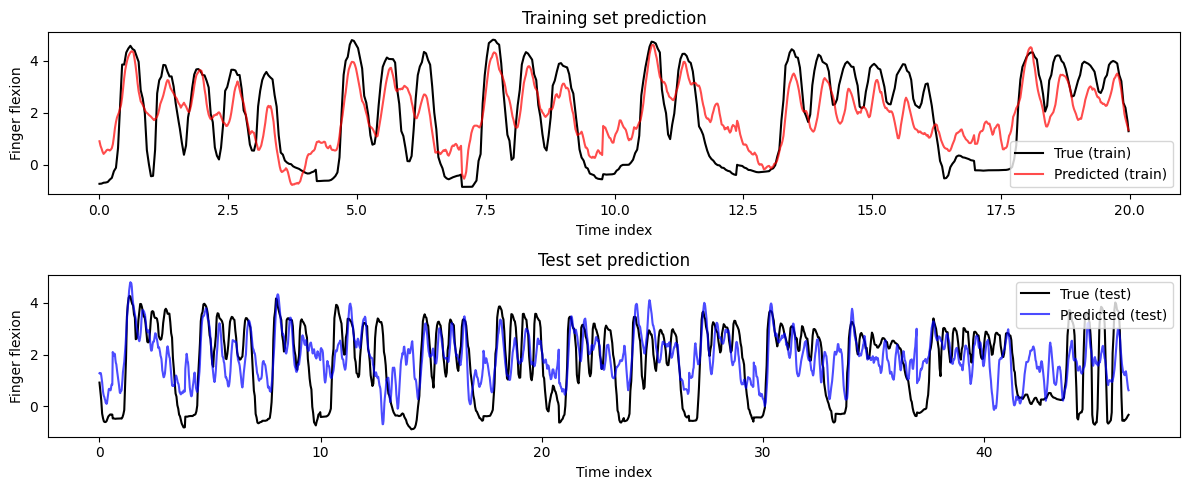

In [35]:

ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Y_train_pred_best_lasso, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Y_test_pred_best_lasso, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The Lasso model with the optimal λ captures the main oscillations and overall shape of the finger flexion on both training and test sets.
On the training set, the red curve follows the true signal fairly well but remains smoother, showing the effect of regularization.
On the test set, the blue curve reproduces the general trend of the movement but with less precision in amplitude and timing.
Overall, the Lasso model achieves reasonable generalization while avoiding the overfitting observed with Least Squares.

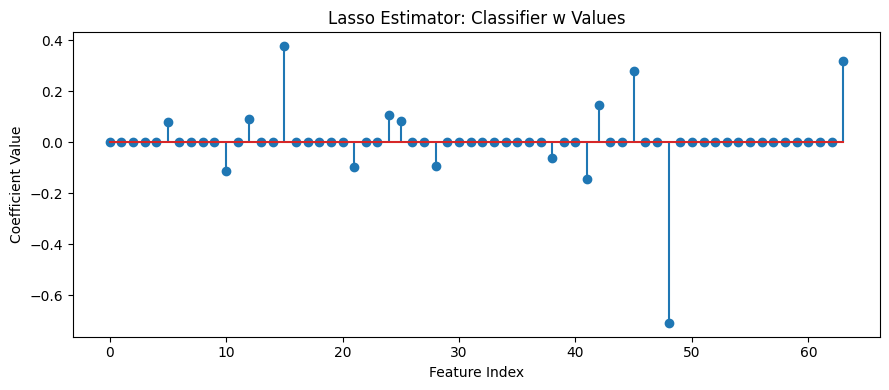

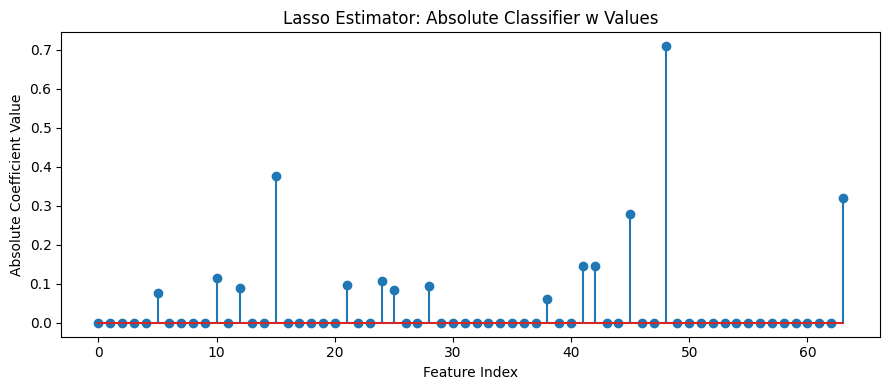

In [36]:
# Plot the values of the classifiers w for Lasso estimator
plt.figure(figsize=(9, 4))

# Plot the values of w for Lasso estimator
plt.stem(lasso_model_best.coef_)
plt.title('Lasso Estimator: Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

# Plot the absolute values of w for Lasso estimator
plt.figure(figsize=(9, 4))

# Plot the absolute values of w for Lasso estimator
plt.stem(np.abs(lasso_model_best.coef_))
plt.title('Lasso Estimator: Absolute Classifier w Values')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

Using Variable selection with the Lasso can help identify the most relevant features for predicting finger flexion, reducing model complexity and improving generalization. By selecting only the most informative features, we can build a simpler model that captures the essential information in the data, leading to better performance on unseen data.

In [44]:
# Get the absolute values of the coefficients
coefficients = np.abs(lasso_model_best.coef_)

# Get the indices of the 2 most important features
important_features_indices = np.argsort(coefficients)
important_features_indices = [int(i) for i in important_features_indices if coefficients[i]!=0]

print("Indices of the most important features: ",important_features_indices[::-1] )
print("Indices of the 2 most important features:", important_features_indices[::-1][:2])

Indices of the most important features:  [48, 15, 63, 45, 42, 41, 10, 24, 21, 28, 12, 25, 5, 38]
Indices of the 2 most important features: [48, 15]


The most important features selected by the Lasso model are those with the higher absolute values of the coefficients. These features are considered the most relevant for predicting finger flexion, as they contribute the most to the model's predictions. We can observe that variables 48 and 45 are in the list which justify our interpretations in the "Data visualization and pre-processing
" part. By focusing on these features, we can build a more interpretable and efficient model that captures the essential information in the data.

In [45]:
# Count the number of non-zero coefficients
selected_features_count = np.sum(coefficients != 0)

print("Number of features selected by the Lasso model:", selected_features_count)

Number of features selected by the Lasso model: 14


We can reduce the number of electrodes used in the ECoG signal to only the most relevant ones selected by the Lasso model. This can help simplify the model, reduce computational complexity, and improve generalization to new, unseen data

**Nonlinear regression**

***Random Forest Regression***

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with default parameters
rf_model = RandomForestRegressor()

# Fit the model on the training data
rf_model.fit(Xtrain, Ytrain.ravel())

# Make predictions on the training and test sets
Y_train_pred_rf = rf_model.predict(Xtrain)
Y_test_pred_rf = rf_model.predict(Xtest)

# Compute MSE and R² for the training set
mse_train_rf = mean_squared_error(Ytrain, Y_train_pred_rf)
r2_train_rf = r2_score(Ytrain, Y_train_pred_rf)

# Compute MSE and R² for the test set
mse_test_rf = mean_squared_error(Ytest, Y_test_pred_rf)
r2_test_rf = r2_score(Ytest, Y_test_pred_rf)

print(f"Random Forest Training MSE: {mse_train_rf:.4f}")
print(f"Random Forest Training R²: {r2_train_rf:.4f}")
print(f"Random Forest Test MSE: {mse_test_rf:.4f}")
print(f"Random Forest Test R²: {r2_test_rf:.4f}")

Random Forest Training MSE: 0.0217
Random Forest Training R²: 0.9931
Random Forest Test MSE: 1.6377
Random Forest Test R²: 0.2320


Random Forest regression does not outperform the Lasso and Ridge regression models in terms of test Mean Squared Error (MSE) and R² values. The Random Forest has a test MSE of 1.6377 and a test R² of 0.2320, which are worse than the Lasso's best test MSE of 1.3660 and R² of 0.3595, and also worse than the Ridge's test MSE of 1.6239 and R² of 0.2385. While Random Forest shows excellent training performance (with a training MSE of 0.0217 and R² of 0.9931), this suggests overfitting, as it performs poorly on unseen data. Therefore, in this case, Random Forest is not the better model compared to Lasso and Ridge regression.

In order to find the best parameters of the model, we use GridSearchCV from sklearn directly instead of doing manually loops over parameters and using cross validation in each one.

In [48]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ["sqrt", 0.5, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5,
                           verbose=2, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(Xtrain, Ytrain.ravel())

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
Y_train_pred_best_rf = best_rf_model.predict(Xtrain)
Y_test_pred_best_rf = best_rf_model.predict(Xtest)

# Compute MSE and R² for the best model
mse_train_best_rf = mean_squared_error(Ytrain, Y_train_pred_best_rf)
r2_train_best_rf = r2_score(Ytrain, Y_train_pred_best_rf)

mse_test_best_rf = mean_squared_error(Ytest, Y_test_pred_best_rf)
r2_test_best_rf = r2_score(Ytest, Y_test_pred_best_rf)

print(f"Best Random Forest Training MSE: {mse_train_best_rf:.4f}")
print(f"Best Random Forest Training R²: {r2_train_best_rf:.4f}")
print(f"Best Random Forest Test MSE: {mse_test_best_rf:.4f}")
print(f"Best Random Forest Test R²: {r2_test_best_rf:.4f}")
print("Best Parameters:", best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Training MSE: 0.0233
Best Random Forest Training R²: 0.9926
Best Random Forest Test MSE: 1.5945
Best Random Forest Test R²: 0.2523
Best Parameters: {'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}


The significant gap between training and test metrics in this case indicates that while the parameters selected improved performance somewhat, there may still be room for further tuning or a reevaluation of feature selection or model choice.

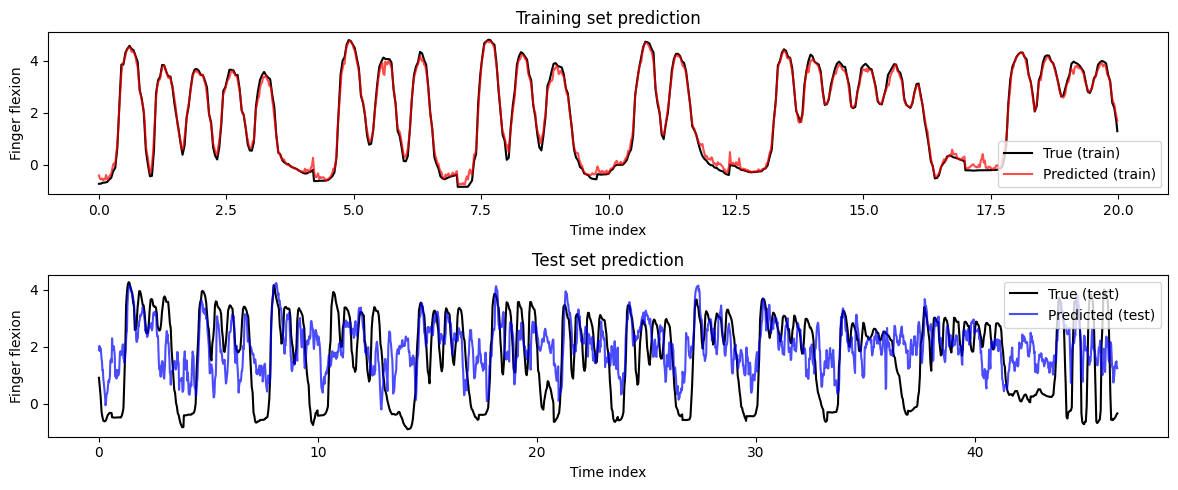

In [49]:

ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Y_train_pred_best_rf, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Y_test_pred_best_rf, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The Random Forest model fits the training data almost perfectly, but the test predictions (blue curve) deviate strongly from the true signal and fail to reproduce its detailed shape. This shows clear overfitting: the model memorizes the training set but generalizes poorly to unseen data. Overall, the Random Forest regression performs worse than the linear models, indicating that its complexity does not suit this dataset

***Support Vector Regression***

In [50]:
from sklearn.svm import SVR

# Initialize the model with default parameters
svr_model = SVR()

# Fit the model on the training data
svr_model.fit(Xtrain, Ytrain.ravel())

# Make predictions on the training and test sets
Y_train_pred_svr = svr_model.predict(Xtrain)
Y_test_pred_svr = svr_model.predict(Xtest)

# Compute MSE and R² for the training set
mse_train_svr = mean_squared_error(Ytrain, Y_train_pred_svr)
r2_train_svr = r2_score(Ytrain, Y_train_pred_svr)

# Compute MSE and R² for the test set
mse_test_svr = mean_squared_error(Ytest, Y_test_pred_svr)
r2_test_svr = r2_score(Ytest, Y_test_pred_svr)

print(f"SVR Training MSE: {mse_train_svr:.4f}")
print(f"SVR Training R²: {r2_train_svr:.4f}")
print(f"SVR Test MSE: {mse_test_svr:.4f}")
print(f"SVR Test R²: {r2_test_svr:.4f}")

SVR Training MSE: 0.0241
SVR Training R²: 0.9923
SVR Test MSE: 1.5152
SVR Test R²: 0.2895


The Support Vector Regressor (SVR) exhibits strong performance relative to other regression techniques, with a test Mean Squared Error (MSE) of 1.5152 and an R² of 0.2895. Although it does not surpass the Lasso model, SVR remains a solid alternative to Least Squares, Ridge, and Random Forest regression. Further hyperparameter tuning could potentially improve its performance even more.

In [51]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']  # Only relevant for 'rbf'
}

# Initialize SVR
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(Xtrain, Ytrain.ravel())

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated MSE: ", -grid_search.best_score_)

Best parameters found:  {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validated MSE:  1.6696735519459238


In [52]:
# Get best parameters and estimator
best_params = grid_search.best_params_
best_svr_model = grid_search.best_estimator_

# Make predictions with the best model
Y_train_pred_best_svr = best_svr_model.predict(Xtrain)
Y_test_pred_best_svr = best_svr_model.predict(Xtest)

# Compute MSE and R² for the best model
mse_train_best_svr = mean_squared_error(Ytrain, Y_train_pred_best_svr)
r2_train_best_svr = r2_score(Ytrain, Y_train_pred_best_svr)

mse_test_best_svr = mean_squared_error(Ytest, Y_test_pred_best_svr)
r2_test_best_svr = r2_score(Ytest, Y_test_pred_best_svr)

print(f"Best SVR Training MSE: {mse_train_best_svr:.4f}")
print(f"Best SVR Training R²: {r2_train_best_svr:.4f}")
print(f"Best SVR Test MSE: {mse_test_best_svr:.4f}")
print(f"Best SVR Test R²: {r2_test_best_svr:.4f}")

Best SVR Training MSE: 0.0018
Best SVR Training R²: 0.9994
Best SVR Test MSE: 1.5325
Best SVR Test R²: 0.2814


Here, the performance of the SVR model isn't dependent on the parameters selected, as the default hyperparameters already yield to the same results.

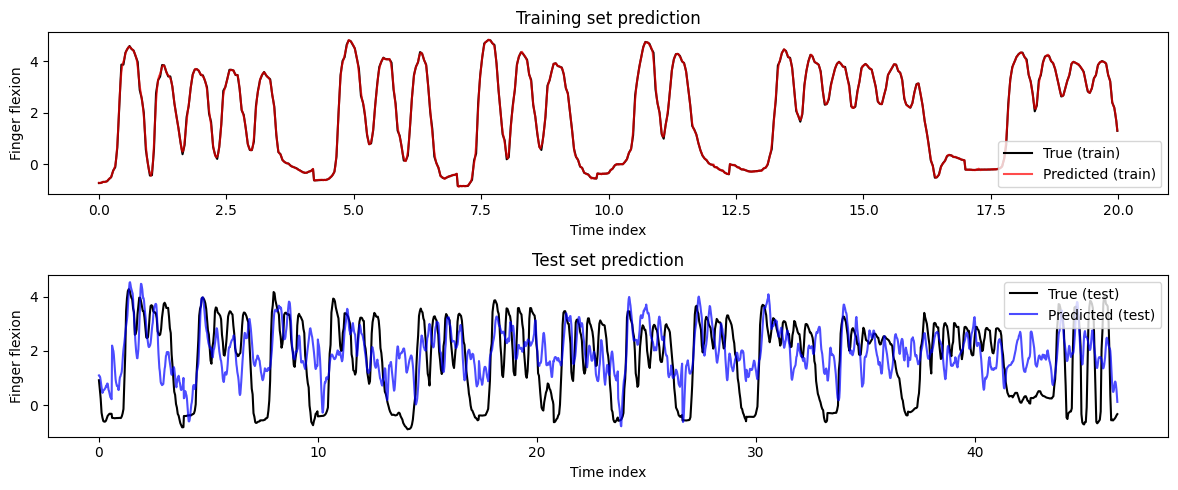

In [53]:
ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Y_train_pred_best_svr, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Y_test_pred_best_svr, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The Support Vector Regressor (SVR) shows promising results, achieving a training Mean Squared Error (MSE) of 0.0018 and an R² of 0.9994, indicating excellent fit on the training data. However, the test MSE of 1.5325 and an R² of 0.2814 suggest that the model struggles to generalize to unseen data. The relatively low test R² indicates that the SVR does not explain much variance in the test set, which raises concerns about overfitting. Plots show that while SVR demonstrates strong training performance, the disparity between training and test results indicates that further optimization and validation are necessary to enhance its generalization capability.

**MLPClassifier**

In [54]:
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor with default parameters
mlp_model = MLPRegressor()

# Fit the model on the training data
mlp_model.fit(Xtrain, Ytrain.ravel())

# Make predictions on the training and test sets
Y_train_pred_mlp = mlp_model.predict(Xtrain)
Y_test_pred_mlp = mlp_model.predict(Xtest)

# Compute MSE and R² for the training set
mse_train_mlp = mean_squared_error(Ytrain, Y_train_pred_mlp)
r2_train_mlp = r2_score(Ytrain, Y_train_pred_mlp)

# Compute MSE and R² for the test set
mse_test_mlp = mean_squared_error(Ytest, Y_test_pred_mlp)
r2_test_mlp = r2_score(Ytest, Y_test_pred_mlp)

print(f"MLP Training MSE: {mse_train_mlp:.4f}")
print(f"MLP Training R²: {r2_train_mlp:.4f}")
print(f"MLP Test MSE: {mse_test_mlp:.4f}")
print(f"MLP Test R²: {r2_test_mlp:.4f}")

MLP Training MSE: 0.0076
MLP Training R²: 0.9976
MLP Test MSE: 2.4317
MLP Test R²: -0.1403


The Multi-Layer Perceptron Regressor (MLPRegressor) results show a training Mean Squared Error (MSE) of 0.0076 and an R² of 0.9976, indicating an excellent fit on the training data. However, its test MSE of 2.4317 and R² of -0.1403 suggest that the model fails to generalize to unseen data, as evidenced by the negative R² value, which indicates that the model performs worse than a horizontal line representing the mean of the target variable. The MLPRegressor has a lower test MSE (2.2821) than LS (3.0455) but performs worse than both Ridge and Lasso in terms of MSE and R² on the test set. All models exhibit some degree of overfitting; however, the MLPRegressor demonstrates a significant drop in test performance compared to its training performance.

In [55]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
}

# Initialize the MLPRegressor
mlp_model = MLPRegressor()

# Setup GridSearchCV
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(Xtrain, Ytrain.ravel())

# Best parameters and score
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}


In [56]:
# Get best parameters and estimator
best_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_

# Make predictions with the best model
Y_train_pred_best_mlp = best_mlp_model.predict(Xtrain)
Y_test_pred_best_mlp = best_mlp_model.predict(Xtest)

# Compute MSE and R² for the best model
mse_train_best_mlp = mean_squared_error(Ytrain, Y_train_pred_best_mlp)
r2_train_best_mlp = r2_score(Ytrain, Y_train_pred_best_mlp)

mse_test_best_mlp = mean_squared_error(Ytest, Y_test_pred_best_mlp)
r2_test_best_mlp = r2_score(Ytest, Y_test_pred_best_mlp)

print(f"Best MLP Training MSE: {mse_train_best_mlp:.4f}")
print(f"Best MLP Training R²: {r2_train_best_mlp:.4f}")
print(f"Best MLP Test MSE: {mse_test_best_mlp:.4f}")
print(f"Best MLP Test R²: {r2_test_best_mlp:.4f}")

Best MLP Training MSE: 0.0043
Best MLP Training R²: 0.9986
Best MLP Test MSE: 2.4507
Best MLP Test R²: -0.1492


Using the MLPRegressor, the performance is dependent on the hyperparameters selected, as different configurations can lead to varying results. In this case, the default hyperparameters do not yield optimal performance, as the model struggles to generalize to unseen data. Further hyperparameter tuning, feature engineering, or regularization may be necessary to improve the model's generalization capability.

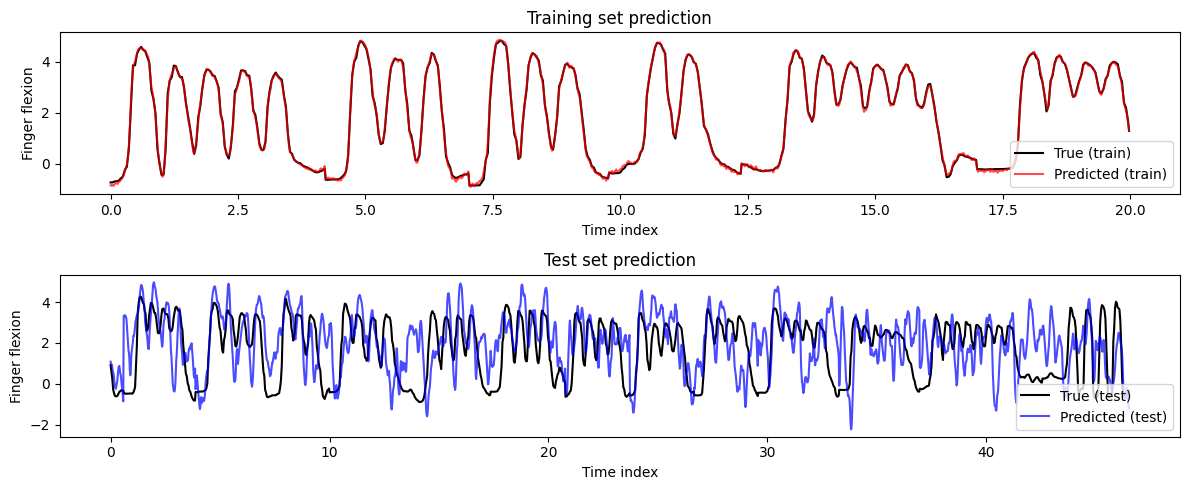

In [57]:
ttrain = np.arange(Xtrain.shape[0]) / Fe
ttrain=ttrain.ravel()  # Ensure t is 1D

ttest= np.arange(Xtest.shape[0]) / Fe
ttest=ttest.ravel()  # Ensure t is 1D


# Plot the predictions vs true values
plt.figure(figsize=(12,5))

plt.subplot(2, 1, 1)
plt.plot(ttrain, Ytrain, label="True (train)", color="black")
plt.plot(ttrain, Y_train_pred_best_mlp, label="Predicted (train)", color="red", alpha=0.7)
plt.title("Training set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ttest, Ytest, label="True (test)", color="black")
plt.plot(ttest, Y_test_pred_best_mlp, label="Predicted (test)", color="blue", alpha=0.7)
plt.title("Test set prediction")
plt.xlabel("Time index")
plt.ylabel("Finger flexion")
plt.legend()

plt.tight_layout()
plt.show()

The MLPRegressor struggles to generalize effectively to unseen data. This performance suggests potential overfitting, where the model learns the noise in the training data rather than the underlying patterns. Overall, while MLP can be a powerful regression technique due to its ability to model complex relationships, its efficacy depends significantly on more proper tuning and regularization to ensure good generalization on test data.

**Final comparison of the performances**

In [59]:
import pandas as pd
results = {
    'Model': ['Least Squares regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'SVR', 'MLP'],
    'Test MSE': [mse_test, mse_test_ridge_best, mse_test_best_lasso, mse_test_best_rf, mse_test_best_svr, mse_test_best_mlp],
    'Test R²': [r2_test, r2_test_ridge_best, r2_test_best_lasso, r2_test_best_rf, r2_test_best_svr, r2_test_best_mlp]
}
results_df = pd.DataFrame(results)
print(results_df)

                      Model  Test MSE   Test R²
0  Least Squares regression  2.190676 -0.428170
1          Ridge Regression  1.623906  0.238488
2          Lasso Regression  1.365954  0.359451
3             Random Forest  1.594474  0.252290
4                       SVR  1.532462  0.281369
5                       MLP  2.450742 -0.149248


In practical terms, Lasso Regression and Support Vector Regression (SVR) demonstrate the best performance based on the test Mean Squared Error (MSE) and
 metrics.

Both models outperform Least Squares, Ridge, Random Forest, and MLP on the test set, showing that regularization (Lasso) and Support Vector Regression (SVR) can offer practical advantages for predictive accuracy and generalization.

**What are the most interpretable models?**

Least Squares (Linear Regression), Ridge Regression, and Lasso Regression are the most interpretable. Least Squares (Linear Regression): This model is often the easiest to interpret, as it provides coefficients that directly indicate the effect of each feature on the output. Ridge also provides an interpretable linear model with coefficients, though it adds a small regularization term. The regularization can slightly reduce individual coefficient values, but the model’s structure remains interpretable. Lasso Regression: Lasso is similar to Ridge in interpretability, but it tends to drive some coefficients to zero, effectively performing feature selection. This can simplify the model and make it more interpretable by focusing on the most relevant features.

On the other hand, Random Forest, Support Vector Regression (SVR), and Multi-Layer Perceptron (MLP) are less interpretable.

**Which model is best from a medical/practical perspective?**

From a medical or practical perspective, a model that balances interpretability and predictive accuracy is often preferred. This enables healthcare professionals to understand the model's decision-making process and potentially gain insights into brain-signal-to-movement relationships.

Lasso's interpretability makes it advantageous in a medical setting, as it can highlight the most critical ECoG features influencing thumb flexion prediction. Its sparse solution (selecting only the most relevant features) simplifies analysis and could potentially help isolate important brain regions or signal patterns, which is insightful for clinicians.

**Do we need non-linearity in this application?**

The non-linear models like Random Forest and MLP didn’t yield optimal results on the test set, which might suggest that their additional complexity didn’t translate into better generalization for this specific dataset.

**Is validation on the test data a good practice?**

Validation on the test data is indeed a crucial practice, but it should be done with caution. The test dataset serves as an independent evaluation of the model’s performance and helps ensure that the model generalizes well to unseen data. However, over-reliance on test data can lead to overfitting, where the model performs well on test data but poorly in real-world scenarios.

**What would you do if you need to provide a model to a client for prediction in production?**

When providing a model to a client for prediction in a production environment, I would implement a comprehensive strategy to ensure its effectiveness and reliability. First, I would ensure a robust train-validation-test split during the model development phase, allowing for thorough evaluation and tuning of the model’s performance without biasing the final test results. Once the model is ready, I would document its architecture, hyperparameters, and expected performance metrics, providing the client with clear guidelines on its usage and limitations.

Importantly, I would establish a monitoring system to track the model's performance in real-time once deployed. This involves regularly evaluating its predictions against actual outcomes to detect any drift or degradation in performance. If the model's accuracy diminishes over time due to changes in the underlying data patterns, I would recommend periodic retraining or fine-tuning to maintain its predictive capabilities.

**Conclusion**

This session provided a practical understanding of different regression methods, from simple linear regression to more advanced models such as Ridge, Lasso, Random Forest, and Support Vector Regression. By comparing their performances, I observed how regularization (Ridge and Lasso) can improve generalization and how nonlinear models can capture more complex relationships, although they may require careful parameter tuning.

Implementing and testing the models helped me understand the trade-offs between bias and variance, interpretability and flexibility. Overall, this practical work strengthened my intuition about regression techniques and how to select and evaluate them for real-world data analysis.